In [9]:
!pip install datasets evaluate seqeval torchcrf pytorch-crf sklearn_crfsuite  wget -q

Loading CoNLL-2003 dataset...
Dataset loaded: 14041 training, 3250 validation, 3453 test examples
Vocabulary size: 23625
Tag set: ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']
Loading GloVe embeddings...
Found 11974 words with GloVe embeddings
Vocabulary coverage: 50.68%
Using device: cuda

===== Starting Training =====
Training for 25 epochs with batch size 32
Epoch 1, Batch 100, Loss: 4.1894
Epoch 1, Batch 200, Loss: 3.6439
Epoch 1, Batch 300, Loss: 3.9605
Epoch 1, Batch 400, Loss: 2.2399
  New best model saved with F1: 0.5864
Epoch 1/25:
  Train Loss: 4.4872
  Validation - Precision: 0.6150, Recall: 0.5604, F1: 0.5864
  Time: 33.68s
  Learning rate: 0.001000
Epoch 2, Batch 100, Loss: 2.5473
Epoch 2, Batch 200, Loss: 1.5142
Epoch 2, Batch 300, Loss: 1.0440
Epoch 2, Batch 400, Loss: 1.2060
  New best model saved with F1: 0.7464
Epoch 2/25:
  Train Loss: 1.6662
  Validation - Precision: 0.7669, Recall: 0.7270, F1: 0.7464
  Time: 35.54s
  Learning rate:

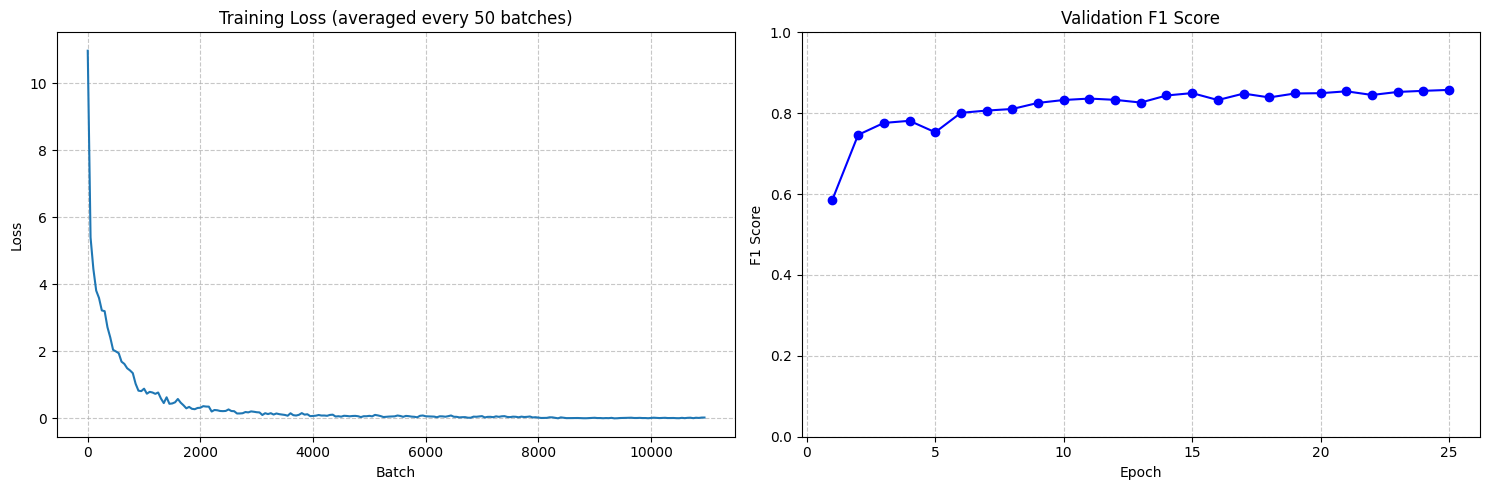

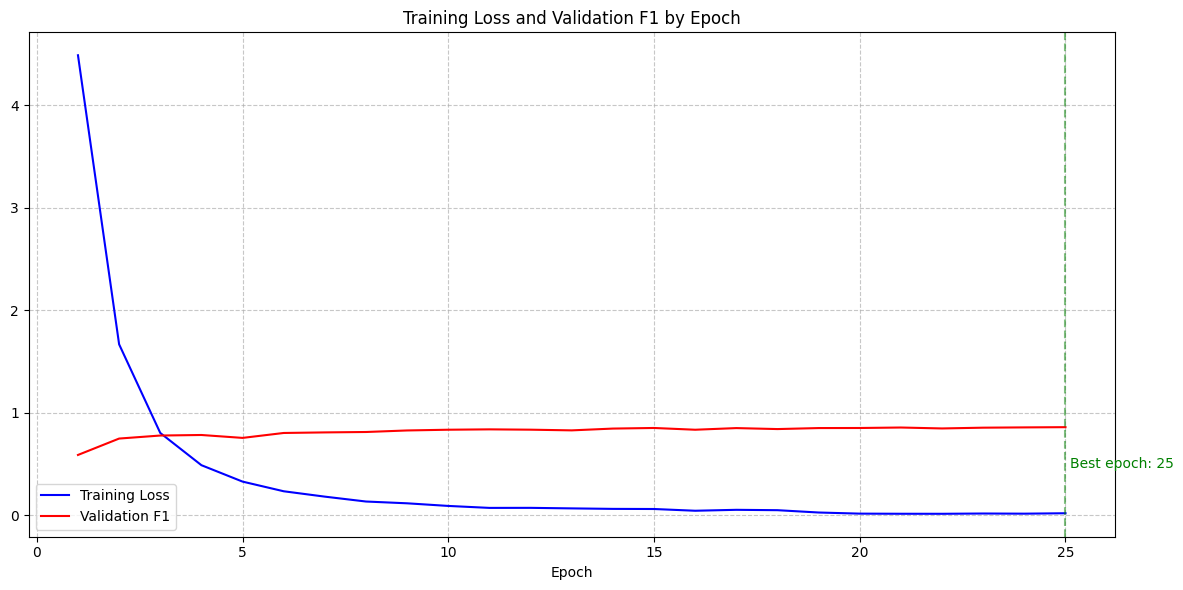


===== Test Set Evaluation =====
Precision: 0.8335
Recall: 0.7355
F1 Score: 0.7814

===== Detailed Classification Report =====
              precision    recall  f1-score   support

         LOC     0.8935    0.7944    0.8410      1668
        MISC     0.7757    0.7094    0.7411       702
         ORG     0.7438    0.7098    0.7264      1661
         PER     0.9042    0.7124    0.7970      1617

   micro avg     0.8335    0.7355    0.7814      5648
   macro avg     0.8293    0.7315    0.7764      5648
weighted avg     0.8379    0.7355    0.7823      5648



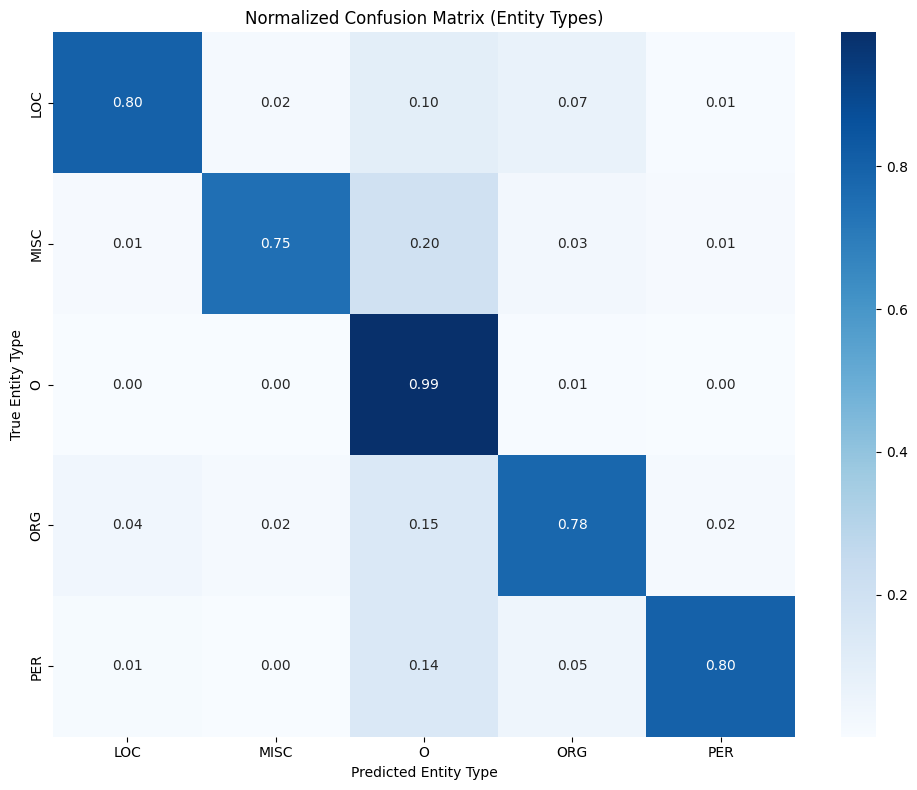


===== Examples =====

Example 1:
Sentence: SOCCER - <UNK> <UNK> <UNK> WIN , CHINA IN <UNK> DEFEAT .
True labels: ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
Predicted labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O', 'O', 'O']
--------------------------------------------------

Example 2:
Sentence: <UNK> <UNK>
True labels: ['B-PER', 'I-PER']
Predicted labels: ['O', 'O']
--------------------------------------------------

Example 3:
Sentence: <UNK> , United Arab Emirates <UNK>
True labels: ['B-LOC', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']
Predicted labels: ['B-ORG', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'I-LOC']
--------------------------------------------------

Example 4:
Sentence: Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
True labels: ['B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torchcrf import CRF
import time
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Preprocessing function for CoNLL data
def preprocess_conll_data(data):
    all_sentences = []
    all_labels = []
    for item in data:
        all_sentences.append(item['tokens'])
        all_labels.append(item['ner_tags'])
    return all_sentences, all_labels

# NER Dataset class
class NERDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

# Collate function for padding sequences in a batch
def collate_fn(batch):
    sentences, labels = zip(*batch)
    max_len = max(len(s) for s in sentences)
    padded_sentences = []
    padded_labels = []
    lengths = []
    for s, l in zip(sentences, labels):
        lengths.append(len(s))
        pad_len = max_len - len(s)
        padded_sentences.append(s + ['<PAD>'] * pad_len)
        padded_labels.append(l + [0] * pad_len)
    return padded_sentences, padded_labels, lengths

# Improved BiLSTM-CRF model with pretrained embeddings
class BiLSTM_CRF(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim, hidden_dim,
                 dropout_rate=0.5, num_layers=2, pretrained_embeddings=None):
        super().__init__()

        # Embedding layer - use pretrained if available
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(
                pretrained_embeddings,
                padding_idx=0,
                freeze=False  # Allow fine-tuning
            )
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Dropout for embeddings
        self.emb_dropout = nn.Dropout(dropout_rate)

        # Multi-layer BiLSTM
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim // 2,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        # Dropout for LSTM output
        self.lstm_dropout = nn.Dropout(dropout_rate)

        # Linear layer to map LSTM output to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

        # CRF layer for sequence tagging
        self.crf = CRF(tagset_size, batch_first=True)

    def forward(self, sentences, lengths, tags=None):
        # Create mask for padding
        mask = (sentences != 0)

        # Get embeddings and apply dropout
        embeds = self.embedding(sentences)
        embeds = self.emb_dropout(embeds)

        # Pack sequences for LSTM
        packed = nn.utils.rnn.pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )

        # Process through LSTM
        lstm_out, _ = self.lstm(packed)

        # Unpack and apply dropout
        unpacked, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        unpacked = self.lstm_dropout(unpacked)

        # Project to tag space
        emissions = self.hidden2tag(unpacked)

        # Either calculate loss or decode sequence
        if tags is not None:
            loss = -self.crf(emissions, tags, mask=mask, reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=mask)

# Function to pad and convert to tensors
def pad_and_tensorize(batch, lengths):
    padded = torch.zeros((len(batch), max(lengths)), dtype=torch.long)
    for i, b in enumerate(batch):
        padded[i, :lengths[i]] = torch.tensor(b[:lengths[i]], dtype=torch.long)
    return padded

# Function to download and load GloVe embeddings
def load_glove_embeddings(word2idx, embedding_dim=100):
    print(f"Loading GloVe embeddings...")

    # Initialize embedding matrix
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))

    # Set padding token to zeros
    embeddings[0] = np.zeros(embedding_dim)

    # Download GloVe if needed
    glove_path = f"glove.6B.{embedding_dim}d.txt"
    if not os.path.exists(glove_path):
        print(f"Downloading GloVe embeddings...")
        import wget
        glove_url = f"https://nlp.stanford.edu/data/glove.6B.zip"
        filename = wget.download(glove_url)

        import zipfile
        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(".")

        print(f"GloVe embeddings downloaded and extracted.")

    # Load embeddings
    try:
        count = 0
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                if word in word2idx:
                    vector = np.array(values[1:], dtype='float32')
                    embeddings[word2idx[word]] = vector
                    count += 1

        print(f"Found {count} words with GloVe embeddings")

        # Print coverage
        coverage = count / len(word2idx) * 100
        print(f"Vocabulary coverage: {coverage:.2f}%")

    except FileNotFoundError:
        print(f"GloVe file not found. Using random embeddings.")

    return torch.FloatTensor(embeddings)

# Function to plot training progress
def plot_training_progress(train_losses, val_f1_scores, save_path='training_progress.png'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss - average every 50 batches for smoother curve
    batch_indices = list(range(0, len(train_losses), 50))
    averaged_losses = [np.mean(train_losses[i:i+50]) for i in batch_indices]

    ax1.plot(batch_indices, averaged_losses)
    ax1.set_title('Training Loss (averaged every 50 batches)')
    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot validation F1 scores
    epochs = range(1, len(val_f1_scores) + 1)
    ax2.plot(epochs, val_f1_scores, 'bo-')
    ax2.set_title('Validation F1 Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_ylim(0, 1.0)

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Function to plot confusion matrix for entity types
def plot_entity_confusion_matrix(y_true, y_pred, labels, save_path='confusion_matrix.png'):
    # Extract just the entity types (without BIO prefixes)
    def extract_entity_type(tag):
        if tag == 'O':
            return 'O'
        return tag.split('-')[1] if '-' in tag else tag

    # Flatten the true and predicted labels
    y_true_flat = [extract_entity_type(item) for sublist in y_true for item in sublist]
    y_pred_flat = [extract_entity_type(item) for sublist in y_pred for item in sublist]

    # Get unique entity types (excluding BIO prefixes)
    entity_types = sorted(set([extract_entity_type(label) for label in labels if label != 'O']) | {'O'})

    # Create confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=entity_types)

    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=entity_types, yticklabels=entity_types, cmap='Blues')
    plt.title('Normalized Confusion Matrix (Entity Types)')
    plt.ylabel('True Entity Type')
    plt.xlabel('Predicted Entity Type')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

def encode(sentences, labels, word2idx, tag2idx):
    encoded_sents = []
    encoded_labels = []
    for sent, lbl in zip(sentences, labels):
        encoded_sents.append([word2idx.get(w, word2idx["<UNK>"]) for w in sent])
        encoded_labels.append(lbl)
    return encoded_sents, encoded_labels

# Plot performance metrics by epoch
def plot_metrics_by_epoch(train_losses_by_epoch, val_f1_scores, save_path='metrics_by_epoch.png'):
    plt.figure(figsize=(12, 6))

    # Plot training loss and validation F1 on the same plot
    epochs = range(1, len(train_losses_by_epoch) + 1)

    plt.plot(epochs, train_losses_by_epoch, 'b-', label='Training Loss')
    plt.plot(epochs, val_f1_scores, 'r-', label='Validation F1')

    plt.title('Training Loss and Validation F1 by Epoch')
    plt.xlabel('Epoch')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add annotations for best epoch
    best_epoch = val_f1_scores.index(max(val_f1_scores)) + 1
    plt.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5)
    plt.text(best_epoch + 0.1, 0.5, f'Best epoch: {best_epoch}',
             verticalalignment='center', color='green')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

# Main function
def main():
    print("Loading CoNLL-2003 dataset...")
    raw_datasets = load_dataset("conll2003")

    # Process train, validation and test data
    train_sentences, train_labels = preprocess_conll_data(raw_datasets["train"])
    val_sentences, val_labels = preprocess_conll_data(raw_datasets["validation"])
    test_sentences, test_labels = preprocess_conll_data(raw_datasets["test"])

    print(f"Dataset loaded: {len(train_sentences)} training, {len(val_sentences)} validation, {len(test_sentences)} test examples")

    # Build vocabulary
    word2idx = {"<PAD>": 0, "<UNK>": 1}
    for sentence in train_sentences:
        for word in sentence:
            if word not in word2idx:
                word2idx[word] = len(word2idx)
    idx2word = {v: k for k, v in word2idx.items()}

    # Get labels from dataset
    label_list = raw_datasets["train"].features["ner_tags"].feature.names
    tag2idx = {tag: idx for idx, tag in enumerate(label_list)}
    idx2tag = {v: k for k, v in tag2idx.items()}

    print(f"Vocabulary size: {len(word2idx)}")
    print(f"Tag set: {label_list}")

    # Set embedding parameters
    embedding_dim = 100  # Using GloVe 100d

    # Load GloVe embeddings
    pretrained_embeddings = load_glove_embeddings(word2idx, embedding_dim)

    # Encode sentences and labels
    encoded_train_sents, encoded_train_labels = encode(train_sentences, train_labels, word2idx, tag2idx)
    encoded_val_sents, encoded_val_labels = encode(val_sentences, val_labels, word2idx, tag2idx)
    encoded_test_sents, encoded_test_labels = encode(test_sentences, test_labels, word2idx, tag2idx)

    # Create datasets and data loaders
    train_dataset = NERDataset(encoded_train_sents, encoded_train_labels)
    val_dataset = NERDataset(encoded_val_sents, encoded_val_labels)
    test_dataset = NERDataset(encoded_test_sents, encoded_test_labels)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=0)

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Initialize model
    model = BiLSTM_CRF(
        vocab_size=len(word2idx),
        tagset_size=len(tag2idx),
        embedding_dim=embedding_dim,
        hidden_dim=512,
        dropout_rate=0.2,
        num_layers=3,
        pretrained_embeddings=pretrained_embeddings
    ).to(device)

    # Setup optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

    # Lists to track metrics
    train_losses = []
    train_losses_by_epoch = []
    val_f1_scores = []

    # Training loop
    num_epochs = 25
    best_val_f1 = 0

    print("\n===== Starting Training =====")
    print(f"Training for {num_epochs} epochs with batch size {batch_size}")

    for epoch in range(num_epochs):
        start_time = time.time()

        # Training
        model.train()
        total_loss = 0
        batch_count = 0

        for sents, labels, lengths in train_loader:
            sents_tensor = pad_and_tensorize(sents, lengths).to(device)
            labels_tensor = pad_and_tensorize(labels, lengths).to(device)

            optimizer.zero_grad()
            loss = model(sents_tensor, lengths, labels_tensor)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            total_loss += loss.item()
            train_losses.append(loss.item())
            batch_count += 1

            # Print progress every 100 batches
            if batch_count % 100 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_count}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_loader)
        train_losses_by_epoch.append(avg_loss)

        # Validation
        model.eval()
        true_labels_flat = []
        pred_labels_flat = []
        with torch.no_grad():
            for sents, labels, lengths in val_loader:
                sents_tensor = pad_and_tensorize(sents, lengths).to(device)
                preds = model(sents_tensor, lengths)

                # Convert numeric predictions to string labels for seqeval
                for p, l, length in zip(preds, labels, lengths):
                    true_seq = [idx2tag[idx] for idx in l[:length]]
                    pred_seq = [idx2tag[idx] for idx in p[:length]]
                    true_labels_flat.append(true_seq)
                    pred_labels_flat.append(pred_seq)

        # Calculate validation metrics
        val_precision = precision_score(true_labels_flat, pred_labels_flat)
        val_recall = recall_score(true_labels_flat, pred_labels_flat)
        val_f1 = f1_score(true_labels_flat, pred_labels_flat)
        val_f1_scores.append(val_f1)

        # Update learning rate
        scheduler.step(val_f1)

        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_ner_model.pt')
            print(f"  New best model saved with F1: {val_f1:.4f}")

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"  Train Loss: {avg_loss:.4f}")
        print(f"  Validation - Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        print(f"  Time: {time.time() - start_time:.2f}s")
        print(f"  Learning rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Plot training progress
    plot_training_progress(train_losses, val_f1_scores)

    # Plot metrics by epoch
    plot_metrics_by_epoch(train_losses_by_epoch, val_f1_scores)

    # Load best model for testing
    model.load_state_dict(torch.load('best_ner_model.pt'))

    # Evaluate on test set
    model.eval()
    test_true_labels = []
    test_pred_labels = []
    test_sentences_text = []
    test_predictions_with_text = []

    with torch.no_grad():
        for i, (sents, labels, lengths) in enumerate(test_loader):
            sents_tensor = pad_and_tensorize(sents, lengths).to(device)
            preds = model(sents_tensor, lengths)

            for p, l, length, sent in zip(preds, labels, lengths, sents):
                true_seq = [idx2tag[idx] for idx in l[:length]]
                pred_seq = [idx2tag[idx] for idx in p[:length]]
                test_true_labels.append(true_seq)
                test_pred_labels.append(pred_seq)

                # Save original text for examples
                original_words = [idx2word[s] for s in sent[:length]]
                test_sentences_text.append(original_words)

                # Store the words, true tags, and predicted tags together
                words_with_tags = list(zip(original_words, true_seq, pred_seq))
                test_predictions_with_text.append(words_with_tags)

    # Calculate and print metrics using seqeval
    test_precision = precision_score(test_true_labels, test_pred_labels)
    test_recall = recall_score(test_true_labels, test_pred_labels)
    test_f1 = f1_score(test_true_labels, test_pred_labels)

    print("\n===== Test Set Evaluation =====")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"F1 Score: {test_f1:.4f}")

    # Detailed classification report
    print("\n===== Detailed Classification Report =====")
    report = classification_report(test_true_labels, test_pred_labels, digits=4)
    print(report)

    # Plot confusion matrix
    plot_entity_confusion_matrix(test_true_labels, test_pred_labels, label_list)

    # Display some examples
    print("\n===== Examples =====")
    # Show a few examples
    for i in range(5):
        print(f"\nExample {i+1}:")
        print("Sentence:", " ".join(test_sentences_text[i]))
        print("True labels:", test_true_labels[i])
        print("Predicted labels:", test_pred_labels[i])
        print("-" * 50)

    # Show a few examples with errors
    print("\n===== Examples with Errors =====")
    error_count = 0
    for i, (words, true_labels, pred_labels) in enumerate(zip(test_sentences_text, test_true_labels, test_pred_labels)):
        if true_labels != pred_labels:
            error_positions = [(j, true_labels[j], pred_labels[j]) for j in range(len(true_labels)) if true_labels[j] != pred_labels[j]]

            print(f"\nExample with errors {error_count+1}:")
            print("Sentence:", " ".join(words))
            print("\nErrors:")
            for pos, true_label, pred_label in error_positions:
                print(f"Position {pos}: Word '{words[pos]}', True: {true_label}, Predicted: {pred_label}")
            print("-" * 50)

            error_count += 1
            if error_count >= 5:
                break

if __name__ == "__main__":
    main()